In [1]:
import numpy as np
from pysindy.feature_library import WeakPDELibrary

t = np.arange(0, 10, .1)
u = np.random.randint(0,3,(t.shape[0],2))
functions = [lambda x : np.exp(x), lambda x,y : np.sin(x+y)]
lib = WeakPDELibrary(library_functions=functions,spatiotemporal_grid=t,K=50).fit(u)
print(f"{t.min() = }, {t.max() = }, {u.min() = }, {u.max() = }")
print(f"{lib._get_spatial_endpoints() = }")
print(f"{lib.transform(u).shape = }")
print(f"{lib.get_feature_names() = }")
print(f"{lib.p = }")

t.min() = 0.0, t.max() = 9.9, u.min() = 0, u.max() = 2
lib._get_spatial_endpoints() = (array([0.]), array([9.9]))
lib.transform(u).shape = (50, 3)
lib.get_feature_names() = ['f0(x0)', 'f0(x1)', 'f1(x0,x1)']
lib.p = 4


So I changed the example provided in `/users/cpa/georgem/pysindy/pysindy/feature_library/weak_pde_library.py` because it seemed outdated. So above I initialize 2 dimensional `u(t)` with 20 samples and consistent `t` which is the spatio-temporal grid (in our case just temporal). Because the actual sampling happens with `K` the output shall consist of `K` samples each of dimension 3. Think why is this the case?

To better understand `WeakPDELibrary` read [Reinbold et al 2020](https://link.aps.org/doi/10.1103/PhysRevE.101.010203). It is essential to understand that they integrate over box domains of size `Hx` and `Ht`. In PySINDy the corresponding argument is `H_xt` which defaults to ` = L_xt / 20`, where `L_xt` which is computed from `_get_spatial_endpoints()` (see documentation). 


In [2]:
print(f"{lib.H_xt = }")

lib.H_xt = array([0.495])


As indicated in equation (16) of [Reinbold et al 2020](https://link.aps.org/doi/10.1103/PhysRevE.101.010203) the domains are defined via rescaled variables $\tilde{t}_k = (t - t_k)/H_t$, where $t_k$ is the center of the box domain. The same holds for the spatial domain. The relevant variable is called `xtilde_k` in the code and it is a list of length `K` containing the rescaled spatial domain centers. So each element of `xtilde_k` list is an array whose first index spans possible values inside the box domain along that axis.

The form of the test function looks as follows (by default $p = 4$):

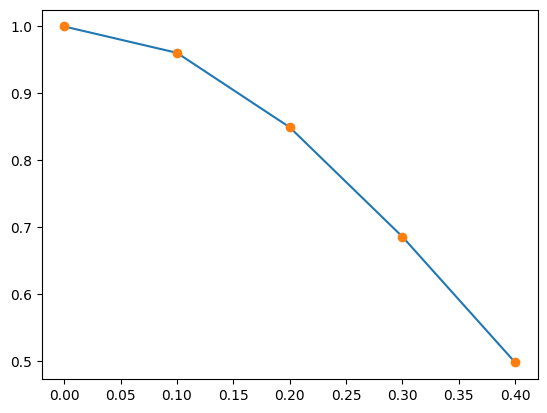

In [3]:
import matplotlib.pyplot as plt
subset_t = t[t<=lib.H_xt]
plt.plot(subset_t,lib._phi(subset_t, 0, None))
plt.plot(subset_t,(1-subset_t**2)**4,'o')

The procedure (see `_set_up_weights()`) will have created indices for space-time points that lie in the domain cells (based on the previous plot we expect 9 to 10 such points). The total number of points is $K = $ `lib.K`. Note that `XT_k` evaluates the (spatio)temporal grid on these domains cells and so it will have the same shape as the indices. `domain_centers` is a list of length `K` containing the centers of the domain cells. The coordinate variable (`t` in our case) are split into these domains and the boundaries between these domains are recorded in `lefts` and `rights`. In general, `lefts` and `rights` are lists that span the number of coordinates. Notice that of some recentering and shrinking of the domain cells there will be `H_xt_k` which has the shape of `K x grid_ndim` and essentially provides local `H_xt` for each cell.

In [54]:
lib.grid_ndim, len(lib.inds_k), lib.inds_k[:20]

(1,
 50,
 [[array([14, 15, 16, 17, 18, 19, 20, 21, 22, 23])],
  [array([64, 65, 66, 67, 68, 69, 70, 71, 72, 73])],
  [array([79, 80, 81, 82, 83, 84, 85, 86, 87, 88])],
  [array([65, 66, 67, 68, 69, 70, 71, 72, 73, 74])],
  [array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29])],
  [array([25, 26, 27, 28, 29, 30, 31, 32, 33, 34])],
  [array([14, 15, 16, 17, 18, 19, 20, 21, 22])],
  [array([75, 76, 77, 78, 79, 80, 81, 82, 83, 84])],
  [array([73, 74, 75, 76, 77, 78, 79, 80, 81, 82])],
  [array([29, 30, 31, 32, 33, 34, 35, 36, 37, 38])],
  [array([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18])],
  [array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39])],
  [array([34, 35, 36, 37, 38, 39, 40, 41, 42, 43])],
  [array([35, 36, 37, 38, 39, 40, 41, 42, 43, 44])],
  [array([63, 64, 65, 66, 67, 68, 69, 70, 71, 72])],
  [array([55, 56, 57, 58, 59, 60, 61, 62, 63, 64])],
  [array([85, 86, 87, 88, 89, 90, 91, 92, 93, 94])],
  [array([38, 39, 40, 41, 42, 43, 44, 45, 46, 47])],
  [array([57, 58, 59, 60, 61, 62, 63, 64,

The shapes of these arrays are recorded in `shapes_k`, i.e. in this simple case it will consist of lengths of the arrays above, such as 10s and 9s. You might get only 10s, because the sampling happens randomly: it depends on `domain_centers` if they align perfectly with the grid.

The next step is to compute the weights which are the products over the weights in each dimension (in our case this is just 1, because no spatial dimension was given). The coordinates in `xtilde_k` are stacked together for each axis (1 in our case) to form `grids` (this produces normalized grid), making `grids` nearly periodic. 

The next step is to compute the weights over the grid and prepare the necessary prerequisites which will enable computing integrals and derivatives. In the process of computing the weights `grids` is taken to vary linearly between the cell points.  These objects, such as `tweights`, useful for time integrals along each axis have the same shape as each element of `grids`. There are also weights for pure derivative terms along each axis `weights0` and mixed library derivative terms `weights1`. A tensor product of these is taken over the axes to produce `fullweights` for time derivatives, `fullweights0` for pure derivative terms, `fullweights1` for mixed derivatives.

In [5]:
len(lib.fulltweights), len(lib.fullweights0), len(lib.fullweights1)

(50, 50, 50)

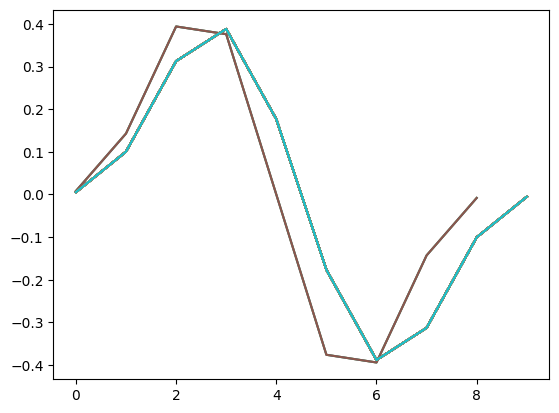

In [70]:
for i in range(lib.K):
    plt.plot(lib.fulltweights[i])

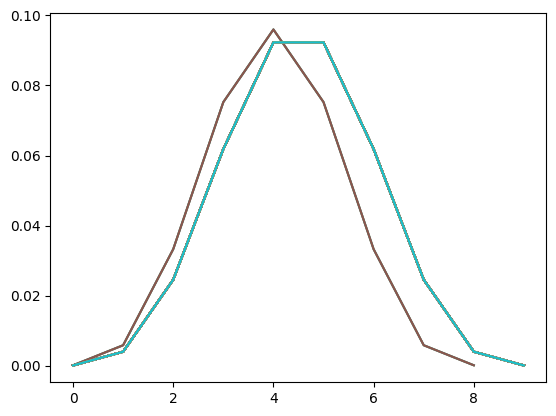

In [73]:
for i in range(lib.K):
    plt.plot(lib.fullweights0[i])

there are no mixed terms in this case

In [77]:
lib.fullweights1[0]

[]

These auxiliary weights are used in the function `transform()`. 


It is good to try a few other examples from [feature library documentation](https://pysindy.readthedocs.io/en/latest/api/pysindy.feature_library.html#module-pysindy.feature_library.weak_pde_library) such as `CustomLibrary` which does result in the expected behavior:

In [31]:
import numpy as np
from pysindy.feature_library import CustomLibrary
x = np.array([[0.,-1],[1.,0.],[2.,-1.]])
functions = [lambda x : x * x, lambda x,y : x + y * y]
lib = CustomLibrary(library_functions=functions).fit(x)
print(f"{lib.transform(x) = }")
print(f"{lib.get_feature_names() = }")

lib.transform(x) = AxesArray([[0., 1., 1.],
           [1., 0., 1.],
           [4., 1., 3.]])
lib.get_feature_names() = ['f0(x0)', 'f0(x1)', 'f1(x0,x1)']


This can be indeed easily confirmed by evaluating the expression by hand

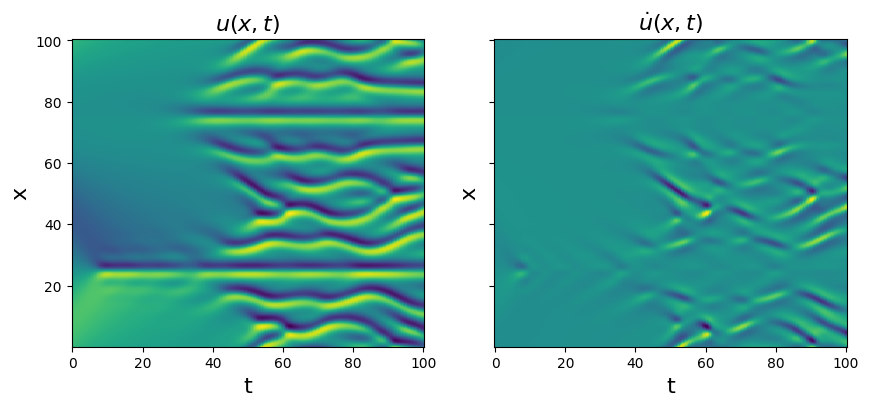

time.min() = 0.0, time.max() = 100.0, x.min() = 0.09817477042468103, x.max() = 100.53096491487338


In [17]:
from scipy.io import loadmat
import pysindy as ps
import matplotlib.pyplot as plt
# Load and plot the data
data = loadmat("../data/kuramoto_sivishinky.mat")
time = np.ravel(data["tt"])
x = np.ravel(data["x"])
u = data["uu"]
dt = time[1] - time[0]
dx = x[1] - x[0]

# Plot u and u_dot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolormesh(time, x, u)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
plt.title(r"$u(x, t)$", fontsize=16)

u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)
plt.subplot(1, 2, 2)
plt.pcolormesh(time, x, u_dot)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\dot{u}(x, t)$", fontsize=16)
plt.show()

u = u.reshape(len(x), len(time), 1)
print(f"{time.min() = }, {time.max() = }, {x.min() = }, {x.max() = }")

In [16]:
# Define weak form PDE library
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
X, T = np.meshgrid(x, time)
XT = np.asarray([X, T]).T
pde_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=4,
    spatiotemporal_grid=XT,
    is_uniform=True,
    K=200,
    include_interaction=True,
    periodic=True,
)
pde_lib._get_spatial_endpoints()

(array([0.09817477, 0.        ]), array([100.53096491, 100.        ]))

Explore the same questions using this more complicated example 